In [19]:
# =============================================================
# 🧩 A. Generar dataset “tileado” a partir de los JSON actuales
# =============================================================
import os, json, math, cv2
from tqdm import tqdm
from pathlib import Path

# =============================================================
# 📂 RUTAS LOCALES
# =============================================================
SRC_IMG = {
  "train": r"C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\train",
  "val":   r"C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\val",
  "test":  r"C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\test",
}
SRC_JSON = {
  "train": r"C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\groundtruth\json_converted\train_converted.json",
  "val":   r"C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\groundtruth\json_converted\val_converted.json",
  "test":  r"C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\groundtruth\json_converted\test_converted.json",
}
OUT_ROOT = r"C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\tiles"

# =============================================================
# ⚙️ PARÁMETROS DE TILEADO
# =============================================================
TILE = 1024        # lado del tile
OVERLAP = 128      # solape en píxeles
MIN_VIS_FRAC = 0.3 # fracción mínima visible para conservar una bbox

os.makedirs(OUT_ROOT, exist_ok=True)
os.makedirs(f"{OUT_ROOT}/annotations", exist_ok=True)

# =============================================================
# 🔧 FUNCIONES AUXILIARES
# =============================================================
def load_json(p): 
    with open(p, 'r', encoding='utf-8') as f: 
        return json.load(f)

def coco_index(coco):
    """Indexa anotaciones por imagen."""
    by_img = {}
    for img in coco["images"]:
        by_img[img["id"]] = {**img, "anns":[]}
    for ann in coco["annotations"]:
        by_img[ann["image_id"]]["anns"].append(ann)
    return by_img

def intersect_box(box, win):
    # box, win: [x1,y1,x2,y2]
    x1 = max(box[0], win[0]); y1 = max(box[1], win[1])
    x2 = min(box[2], win[2]); y2 = min(box[3], win[3])
    return [x1, y1, x2, y2]

def area(box):
    return max(0, box[2]-box[0]) * max(0, box[3]-box[1])

def clamp_to_tile(box, tx, ty):
    # conv a coords locales del tile y clamp
    x1, y1, x2, y2 = box
    return [x1-tx, y1-ty, x2-tx, y2-ty]

def to_xyxy(b):
    # COCO [x,y,w,h] -> [x1,y1,x2,y2]
    return [b[0], b[1], b[0]+b[2], b[1]+b[3]]

def to_xywh(b):
    # [x1,y1,x2,y2] -> COCO [x,y,w,h]
    return [float(b[0]), float(b[1]), float(b[2]-b[0]), float(b[3]-b[1])]

# =============================================================
# 🧱 FUNCIÓN PRINCIPAL DE TILEADO
# =============================================================
def tile_split(split, limit=None):
    coco = load_json(SRC_JSON[split])
    idx = coco_index(coco)
    out_imgs, out_anns = [], []
    out_dir = f"{OUT_ROOT}/{split}_{TILE}_ov{OVERLAP}"
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    new_img_id = 1
    new_ann_id = 1

    keys = sorted(idx.keys())
    if limit:  # para pruebas
        keys = keys[:limit]

    for img_id in tqdm(keys, desc=f"Procesando {split}"):
        meta = idx[img_id]
        img_path = os.path.join(SRC_IMG[split], meta["file_name"])
        img = cv2.imread(img_path)

        if img is None:
            print(f"⚠️ No se pudo leer la imagen: {img_path}")
            continue

        h, w = img.shape[:2]
        step_x = TILE - OVERLAP
        step_y = TILE - OVERLAP

        for ty in range(0, h, step_y):
            for tx in range(0, w, step_x):
                x2 = min(tx + TILE, w)
                y2 = min(ty + TILE, h)

                # descartar tiles pequeños
                if (x2-tx) < TILE//2 or (y2-ty) < TILE//2:
                    continue

                tile_img = img[ty:y2, tx:x2]
                tile_name = f"{Path(meta['file_name']).stem}_{tx}_{ty}.jpg"
                cv2.imwrite(os.path.join(out_dir, tile_name), tile_img)

                tile_anns_this = []
                for ann in meta["anns"]:
                    cat = ann["category_id"]
                    bx = to_xyxy(ann["bbox"])
                    inter = intersect_box(bx, [tx, ty, x2, y2])
                    if area(inter) <= 0: 
                        continue
                    vis_frac = area(inter) / (area(bx) + 1e-6)
                    if vis_frac < MIN_VIS_FRAC:
                        continue
                    local = clamp_to_tile(inter, tx, ty)
                    if local[2]-local[0] < 2 or local[3]-local[1] < 2:
                        continue
                    tile_anns_this.append({
                        "id": new_ann_id,
                        "image_id": new_img_id,
                        "category_id": int(cat),
                        "bbox": to_xywh(local),
                        "area": float((local[2]-local[0])*(local[3]-local[1])),
                        "iscrowd": 0
                    })
                    new_ann_id += 1

                if len(tile_anns_this) > 0:
                    out_imgs.append({
                        "id": new_img_id,
                        "file_name": tile_name,
                        "height": int(y2-ty),
                        "width": int(x2-tx),
                    })
                    out_anns.extend(tile_anns_this)
                    new_img_id += 1

    out = {
        "info": {"description": f"{split} tiles", "tile": TILE, "overlap": OVERLAP},
        "licenses": [],
        "images": out_imgs,
        "annotations": out_anns,
        "categories": [{"id": i, "name": str(i)} for i in [1,2,3,4,5,6]],
    }

    with open(f"{OUT_ROOT}/annotations/{split}_tiles.json", "w", encoding="utf-8") as f:
        json.dump(out, f, indent=2)

    print(f"✅ {split}: {len(out_imgs)} tiles con {len(out_anns)} bboxes generados.")
    print(f"📄 Guardado en: {OUT_ROOT}/annotations/{split}_tiles.json")

# =============================================================
# 🚀 EJECUCIÓN
# =============================================================

# 🔹 Para prueba rápida (solo 5 imágenes)
# tile_split("train", limit=5)

# 🔹 Para procesar todo el conjunto
# tile_split("train")
tile_split("val")
tile_split("test")


Procesando val: 100%|████████████████████████████████████████████████████████████████| 111/111 [02:38<00:00,  1.43s/it]


✅ val: 444 tiles con 1229 bboxes generados.
📄 Guardado en: C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\tiles/annotations/val_tiles.json


Procesando test: 100%|███████████████████████████████████████████████████████████████| 258/258 [06:18<00:00,  1.47s/it]

✅ test: 837 tiles con 2561 bboxes generados.
📄 Guardado en: C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\tiles/annotations/test_tiles.json


🖼️ Mostrando tile: 0df8cbe13350f5b20d9d4156577709895c315e85_4480_0.jpg
📦 2 cajas detectadas


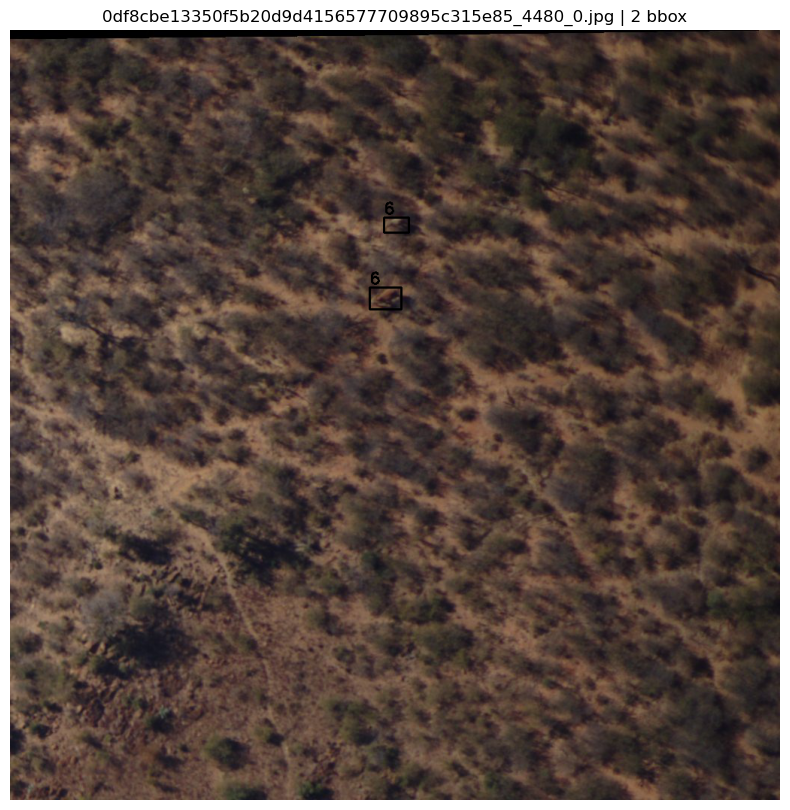

In [18]:
# =============================================================
# 🧩 B. Verificación visual del dataset tileado
# =============================================================
import os, json, random, cv2
from pathlib import Path

# =============================================================
# 📂 RUTAS DEL TILEADO
# =============================================================
OUT_ROOT = r"C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\tiles"
SPLIT = "train"   # Cambia a 'val' o 'test' según lo que quieras revisar

TILE_FOLDER = os.path.join(OUT_ROOT, f"{SPLIT}_1024_ov128")
JSON_PATH = os.path.join(OUT_ROOT, "annotations", f"{SPLIT}_tiles.json")

# =============================================================
# 🎨 COLORES DE CLASES
# =============================================================
CLASS_COLORS = {
    1: (0, 255, 0),     # Verde
    2: (255, 0, 0),     # Rojo
    3: (0, 0, 255),     # Azul
    4: (0, 255, 255),   # Amarillo
    5: (255, 255, 0),   # Cian
    6: (0, 0, 0),       # Negro
}

# =============================================================
# 🔧 FUNCIONES
# =============================================================
def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def draw_boxes(img, anns):
    for ann in anns:
        x, y, w, h = ann["bbox"]
        cat = ann["category_id"]
        color = CLASS_COLORS.get(cat, (255, 255, 255))
        p1 = (int(x), int(y))
        p2 = (int(x + w), int(y + h))
        cv2.rectangle(img, p1, p2, color, 2)
        cv2.putText(img, str(cat), (p1[0], max(15, p1[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    return img

# =============================================================
# 🧩 CARGAR Y VISUALIZAR UN TILE ALEATORIO (versión Jupyter-safe)
# =============================================================
import matplotlib.pyplot as plt

coco = load_json(JSON_PATH)
images = coco["images"]
anns = coco["annotations"]

# Seleccionar imagen aleatoria
img_meta = random.choice(images)
img_name = img_meta["file_name"]
img_path = os.path.join(TILE_FOLDER, img_name)

# Filtrar las anotaciones correspondientes
anns_for_img = [a for a in anns if a["image_id"] == img_meta["id"]]

# Leer y convertir a RGB
img = cv2.imread(img_path)
if img is None:
    print(f"⚠️ No se pudo abrir la imagen: {img_path}")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_vis = draw_boxes(img.copy(), anns_for_img)

    print(f"🖼️ Mostrando tile: {img_name}")
    print(f"📦 {len(anns_for_img)} cajas detectadas")

    plt.figure(figsize=(10,10))
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title(f"{img_name} | {len(anns_for_img)} bbox")
    plt.show()



In [13]:
#B. Entrenar Faster R-CNN sobre tiles
import torch, torchvision, albumentations as A, cv2, json, os
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

class CocoTiles(Dataset):
    def __init__(self, img_dir, ann_json, tfm=None):
        self.img_dir = img_dir
        with open(ann_json) as f: self.coco = json.load(f)
        self.imgs = {im["id"]: im for im in self.coco["images"]}
        self.by_img = {im_id: [] for im_id in self.imgs}
        for ann in self.coco["annotations"]:
            self.by_img[ann["image_id"]].append(ann)
        self.ids = list(self.imgs.keys())
        self.tfm = tfm

    def __len__(self): return len(self.ids)

    def __getitem__(self, i):
        iid = self.ids[i]
        im = self.imgs[iid]
        path = os.path.join(self.img_dir, im["file_name"])
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        boxes, labels = [], []
        for a in self.by_img[iid]:
            x,y,w,h = a["bbox"]
            boxes.append([x,y,x+w,y+h])
            labels.append(int(a["category_id"]))
        if self.tfm:
            t = self.tfm(image=img, bboxes=boxes, class_labels=labels)
            img = t["image"]
            boxes = torch.as_tensor(t["bboxes"], dtype=torch.float32)
            labels = torch.as_tensor(t["class_labels"], dtype=torch.int64)
        else:
            img = torch.from_numpy(img).permute(2,0,1).float()/255.
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        keep = (boxes[:,2]>boxes[:,0]) & (boxes[:,3]>boxes[:,1])
        boxes, labels = boxes[keep], labels[keep]
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([iid])}
        return img, target

def tfms_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.Rotate(limit=8, border_mode=cv2.BORDER_CONSTANT, p=0.3),
        A.ColorJitter(0.2,0.2,0.2,0.02,p=0.3),
        A.MotionBlur(blur_limit=3,p=0.1),
        A.ToFloat(max_value=255.0),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"], min_visibility=0.2))

def tfms_val():
    return A.Compose([A.ToFloat(max_value=255.0), ToTensorV2()],
                     bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

train_ds = CocoTiles(f"{OUT_ROOT}/train_1024_ov128",
                     f"{OUT_ROOT}/annotations/train_tiles.json", tfms_train())
val_ds   = CocoTiles(f"{OUT_ROOT}/val_1024_ov128",
                     f"{OUT_ROOT}/annotations/val_tiles.json", tfms_val())

def collate_fn(b): return tuple(zip(*b))
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_dl   = DataLoader(val_ds, batch_size=4, shuffle=False,num_workers=4, collate_fn=collate_fn)

from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.anchor_utils import AnchorGenerator

anchor_generator = AnchorGenerator(sizes=((16,32,64,128),),
                                   aspect_ratios=((0.5,1.0,2.0),))
model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT", box_detections_per_img=300)
model.rpn.anchor_generator = anchor_generator
num_classes = 1 + 6  # fondo + 6 clases
in_feat = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_feat, num_classes)
model = model.cuda()


ModuleNotFoundError: No module named 'torch'

In [ ]:
#Entrenamiento (igual a lo que ya veníamos usando, ajustando LR y epochs):
import torch
opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=2e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)

def train_one_epoch():
    model.train()
    total=0
    for imgs, targets in train_dl:
        imgs = [im.cuda(non_blocking=True) for im in imgs]
        targets = [{k:v.cuda() if torch.is_tensor(v) else v for k,v in t.items()} for t in targets]
        loss_dict = model(imgs, targets)  # dict
        loss = sum(loss_dict.values())
        opt.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0); opt.step()
        total += loss.item()
    return total/len(train_dl)

@torch.no_grad()
def val_counting_thr(thr=0.5):
    model.eval()
    n_gt=n_pred=0
    for imgs, targets in val_dl:
        imgs = [im.cuda(non_blocking=True) for im in imgs]
        outs = model(imgs)
        for o,t in zip(outs,targets):
            n_gt += len(t["boxes"])
            keep = o["scores"].detach().cpu().numpy() >= thr
            n_pred += int(keep.sum())
    return abs(n_pred-n_gt)/max(1,len(val_ds)), (n_pred, n_gt)

for ep in range(1, 16):
    loss = train_one_epoch()
    mae, (p,g) = val_counting_thr(0.5)
    sched.step()
    print(f"[Epoch {ep:02d}] loss={loss:.3f} | pred={p} vs gt={g} | abs-err/image≈{mae:.2f}")
